In [1]:
import numpy as np
import bz2
from collections import Counter
import re
import nltk
import torch
import math
import random
import keras
from torch import nn
from torch import optim
from torch import Tensor
from torch import LongTensor
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import logging
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
import seaborn as sns

In [2]:
logging.basicConfig(format='%(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')
logging.getLogger().setLevel(logging.INFO)
nn_Softargmax = nn.Softmax  # fix wrong name

In [3]:
train_dir = '/media/data/artifacts/2016/train/'
test_dir = '/media/data/artifacts/2016/vt_test/'
train_labels_dir = '/media/data/artifacts/2016/train_labels.txt'
test_labels_dir = '/media/data/artifacts/2016/vt_test_labels.txt'
word2vec_model_dir = '/media/data/artifacts/2016/final256.model'
model_dir = '/media/data/artifacts/2016/models/'

In [4]:
!wc -l /media/data/artifacts/2016/train_labels.txt

154800 /media/data/artifacts/2016/train_labels.txt


In [5]:
!wc -l /media/data/artifacts/2016/vt_test_labels.txt

2048 /media/data/artifacts/2016/vt_test_labels.txt


In [6]:
x = !ls -l /media/data/artifacts/2016/train | wc -l
len_train = int(x[0]) - 1
y = !ls -l /media/data/artifacts/2016/vt_test | wc -l
len_test = int(y[0]) - 1

In [7]:
print(len_train)
print(len_test)

154800
2048


### Load word2 vec model

In [8]:
word2vec_model = KeyedVectors.load(word2vec_model_dir, mmap='r')

09-Mar-21 17:56:23 - loading Word2VecKeyedVectors object from /media/data/artifacts/2016/final256.model
09-Mar-21 17:56:26 - loading vectors from /media/data/artifacts/2016/final256.model.vectors.npy with mmap=r
09-Mar-21 17:56:26 - setting ignored attribute vectors_norm to None
09-Mar-21 17:56:26 - loaded /media/data/artifacts/2016/final256.model


In [9]:
len(word2vec_model.wv.vocab)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


850193

### Create train and test labels

In [10]:
train_label_dict={}
count = 0
with open(train_labels_dir) as file:
    for _ in range(len_train):
        line  = file.readline().strip().split(",")
#         if line[0] in train_label_dict and line[1] == '0':
#             count+=1
#             print(line[0],line[1])
        train_label_dict[line[0]] = int(line[1])

In [11]:
test_label_dict={}
with open(test_labels_dir) as file:
    for _ in range(len_test):
        line  = file.readline().strip().split(",")
        test_label_dict[line[0]] = int(line[1])

### Create word2index and index2word dict

In [12]:
len(train_label_dict)

154800

In [13]:
len(test_label_dict)

2048

In [14]:
tokenizer = Tokenizer(filters='#\n')
tokenizer.fit_on_texts(word2vec_model.wv.vocab.keys())
word_index = tokenizer.word_index

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [15]:
idx2word = {v: k for k, v in word_index.items()}

In [16]:
len(word_index)

850192

### Create Train and Test Generators

In [17]:
class TrainDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, files_list, labels):
        'Initialization'
        self.labels = labels
        self.files_list = files_list

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.files_list)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.files_list[index]

        train_dir = '/media/data/artifacts/2016/train/'
        # Load data and get label
        #one_file = torch.load(train_dir + ID)
        one_file = open(train_dir + ID,'r').read().strip() 
        # one_file = torch.load(train_dir + ID + '.txt')

        X =  sequence.pad_sequences(tokenizer.texts_to_sequences([one_file]),maxlen=4000, padding='post',truncating='post')
    
        

        if self.labels[ID] == 1:
            y = [0,1]
        else:
            y = [1,0]

        #y = self.labels[ID]
        #y = torch.from_numpy(y)
        y = torch.FloatTensor(y)

        return X.squeeze(), y


In [18]:
class TestDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, files_list, labels):
        'Initialization'
        self.labels = labels
        self.files_list = files_list

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.files_list)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.files_list[index]

        test_dir = '/media/data/artifacts/2016/vt_test/'
        # Load data and get label

        one_file = open(test_dir + ID,'r').read().strip() 

        X =  sequence.pad_sequences(tokenizer.texts_to_sequences([one_file]),maxlen=4000, padding='post',truncating='post')
    
        

        if self.labels[ID] == 1:
            y = [0,1]           #malicious
        else:
            y = [1,0]           #benign

        #y = self.labels[ID]
        #y = torch.from_numpy(y)
        y = torch.FloatTensor(y)

        return X.squeeze(), y

In [19]:
train = list(train_label_dict.keys())
test = list(test_label_dict.keys())
partition = {}
partition['train'] = train
partition['test'] = test
train_labels= train_label_dict
test_labels= test_label_dict

In [20]:
# import itertools
# t=dict(itertools.islice(test_labels.items(),8000))
# partition['test'] = t
# len(t)

In [21]:
params1 = {'batch_size': 4,
          'shuffle': True,
          'drop_last': True,
          'num_workers': 5}

params2 = {'batch_size': 4,
          'shuffle': False,
          'drop_last': True,
          'num_workers': 5}
max_epochs = 1

# Train Generators
train_set = TrainDataset(partition['train'], train_labels)
#training_generator = torch.utils.data.DataLoader(train_set, **params1)
training_set, val_set = torch.utils.data.random_split(train_set, [140800, 14000])
training_generator = torch.utils.data.DataLoader(training_set, **params1)
validation_generator = torch.utils.data.DataLoader(val_set, **params1)

# Test Generators
test_set = TestDataset(partition['test'], test_labels)
test_generator = torch.utils.data.DataLoader(test_set, **params2)



In [22]:
print(len(training_set))
print(len(val_set))
print(len(test_set))

140800
14000
2048


In [23]:
print(len(training_generator))
print(len(validation_generator))
print(len(test_generator))

35200
3500
512


### Check GPU

In [24]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='cuda')

### Training

In [25]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, p, d_input=None):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        if d_input is None:
            d_xq = d_xk = d_xv = d_model
        else:
            d_xq, d_xk, d_xv = d_input
            
        # Make sure that the embedding dimension of model is a multiple of number of heads
        assert d_model % self.num_heads == 0

        self.d_k = d_model // self.num_heads
        
        # These are still of dimension d_model. They will be split into number of heads 
        self.W_q = nn.Linear(d_xq, d_model, bias=False)
        self.W_k = nn.Linear(d_xk, d_model, bias=False)
        self.W_v = nn.Linear(d_xv, d_model, bias=False)
        
        # Outputs of all sub-layers need to be of dimension d_model
        self.W_h = nn.Linear(d_model, d_model)
        
    def scaled_dot_product_attention(self, Q, K, V):
        batch_size = Q.size(0) 
        k_length = K.size(-2) 
        
        # Scaling by d_k so that the soft(arg)max doesnt saturate
        Q = Q / np.sqrt(self.d_k)                         # (bs, n_heads, q_length, dim_per_head)
        scores = torch.matmul(Q, K.transpose(2,3))          # (bs, n_heads, q_length, k_length)
        
        A = nn_Softargmax(dim=-1)(scores)   # (bs, n_heads, q_length, k_length)
        
        # Get the weighted average of the values
        H = torch.matmul(A, V)     # (bs, n_heads, q_length, dim_per_head)

        return H, A 

        
    def split_heads(self, x, batch_size):
        """
        Split the last dimension into (heads X depth)
        Return after transpose to put in shape (batch_size X num_heads X seq_length X d_k)
        """
        return x.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

    def group_heads(self, x, batch_size):
        """
        Combine the heads again to get (batch_size X seq_length X (num_heads times d_k))
        """
        return x.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
    

    def forward(self, X_q, X_k, X_v):
        batch_size, seq_length, dim = X_q.size()

        # After transforming, split into num_heads 
        Q = self.split_heads(self.W_q(X_q), batch_size)  # (bs, n_heads, q_length, dim_per_head)
        K = self.split_heads(self.W_k(X_k), batch_size)  # (bs, n_heads, k_length, dim_per_head)
        V = self.split_heads(self.W_v(X_v), batch_size)  # (bs, n_heads, v_length, dim_per_head)
        
        # Calculate the attention weights for each of the heads
        H_cat, A = self.scaled_dot_product_attention(Q, K, V)
        
        # Put all the heads back together by concat
        H_cat = self.group_heads(H_cat, batch_size)    # (bs, q_length, dim)
        
        # Final linear layer  
        H = self.W_h(H_cat)          # (bs, q_length, dim)
        # print('MHA attn weight shape:', A.shape)
        # print('MHA output shape:', H.shape)
        
        return H, A

In [26]:
class CNN(nn.Module):
    def __init__(self, d_model, hidden_dim, p):
        super().__init__()
        self.k1convL1 = nn.Linear(d_model,    hidden_dim)
        self.k1convL2 = nn.Linear(hidden_dim, d_model)
        self.activation = nn.ReLU()
        
        self.k1convL1 = nn.Linear(d_model,    hidden_dim)
        self.k1convL2 = nn.Linear(hidden_dim, d_model)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.k1convL1(x)
        x = self.activation(x)
        x = self.k1convL2(x)
        return x

In [27]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, conv_hidden_dim, p=0.1):
        super().__init__()

        self.mha = MultiHeadAttention(d_model, num_heads, p)
        self.cnn = CNN(d_model, conv_hidden_dim, p)

        self.layernorm1 = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
        self.layernorm2 = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
    
    def forward(self, x):
        
        # Multi-head attention 
        attn_output, attn_weights = self.mha(x, x, x)  # (batch_size, input_seq_len, d_model)
        
        # Layer norm after adding the residual connection 
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
        
        # Feed forward 
        cnn_output = self.cnn(out1)  # (batch_size, input_seq_len, d_model)
        
        #Second layer norm after adding residual connection 
        out2 = self.layernorm2(out1 + cnn_output)  # (batch_size, input_seq_len, d_model)

        return out2, attn_weights

In [28]:
def create_sinusoidal_embeddings(nb_p, dim, E):
    theta = np.array([
        [p / np.power(10000, 2 * (j // 2) / dim) for j in range(dim)]
        for p in range(nb_p)
    ])
    E[:, 0::2] = torch.FloatTensor(np.sin(theta[:, 0::2]))
    E[:, 1::2] = torch.FloatTensor(np.cos(theta[:, 1::2]))
    E.detach_()
    E.requires_grad = False
    E = E.to(device)

class Embeddings(nn.Module):
    def __init__(self, embedding_matrix, d_model, vocab_size, max_position_embeddings, p):
        super().__init__()
#         self.word_embeddings = nn.Embedding(vocab_size, d_model, padding_idx=0)

        # self.word_embeddings = nn.Embedding(vocab_size, d_model)
        # # pretrained_weight is a numpy matrix of shape (num_embeddings, d_model)
        # self.word_embeddings.weight.data.copy_(torch.from_numpy(embedding_matrix))
        # self.word_embeddings.weight.requires_grad=False

        self.word_embeddings = nn.Embedding.from_pretrained(embedding_matrix,freeze=True)
        # self.word_embeddings = nn.Embedding(vocab_size, d_model)
        # self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        # self.word_embeddings.weight.requires_grad=False
        
        self.position_embeddings = nn.Embedding(max_position_embeddings, d_model)
        create_sinusoidal_embeddings(
            nb_p=max_position_embeddings,
            dim=d_model,
            E=self.position_embeddings.weight
        )

        self.LayerNorm = nn.LayerNorm(d_model, eps=1e-12)

    def forward(self, input_ids):
        seq_length = input_ids.size(1)
        position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device) # (max_seq_length)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)                      # (bs, max_seq_length)
        
        # Get word embeddings for each input id
        word_embeddings = self.word_embeddings(input_ids)                   # (bs, max_seq_length, dim)
        
        # Get position embeddings for each position id 
        position_embeddings = self.position_embeddings(position_ids)        # (bs, max_seq_length, dim)
        
        # Add them both 
        embeddings = word_embeddings + position_embeddings  # (bs, max_seq_length, dim)
        
        # Layer norm 
        embeddings = self.LayerNorm(embeddings)             # (bs, max_seq_length, dim)
        return embeddings

In [29]:
class Encoder(nn.Module):
    def __init__(self,embedding_matrix, num_layers, d_model, num_heads, ff_hidden_dim, input_vocab_size,
               maximum_position_encoding, p=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = Embeddings(embedding_matrix, d_model, input_vocab_size,maximum_position_encoding, p)
        # self.embedding = nn.Embedding.from_pretrained(embedding_matrix,freeze=True)


        self.enc_layers = nn.ModuleList()
        for _ in range(num_layers):
            self.enc_layers.append(EncoderLayer(d_model, num_heads, ff_hidden_dim, p))
        
    def forward(self, x):
        x = self.embedding(x) # Transform to (batch_size, input_seq_length, d_model)

        for i in range(self.num_layers):
            x, attn_weights = self.enc_layers[i](x)

        return x, attn_weights  # (batch_size, input_seq_len, d_model)

In [30]:
class TransformerClassifier(nn.Module):
    def __init__(self,embedding_matrix, num_layers, d_model, num_heads, conv_hidden_dim, input_vocab_size, num_answers):
        super().__init__()
        
        # self.encoder = Encoder(num_layers, d_model, num_heads, conv_hidden_dim, input_vocab_size,
        #                  maximum_position_encoding=10000)
        self.encoder = Encoder(embedding_matrix, num_layers, d_model, num_heads, conv_hidden_dim, input_vocab_size,
                         maximum_position_encoding=40000)
        self.dense = nn.Linear(d_model, 1)
#         self.dense11 = nn.Linear(256, 1)
        self.dropout = nn.Dropout(p=0.2)
        self.tanh = nn.Tanh()
        self.softmax_fc = nn.Softmax(dim=1)
        self.dense2 = nn.Linear(4000, num_answers)

    def forward(self, x):
        x, attn_weights = self.encoder(x)
        # print('out1',x.shape)
        # [100,200,32]
        # print('attn1',attn_weights.shape)
        
        #x, _ = torch.max(x, dim=1)
        out = self.dense(x)
#         out = self.dense11(out)
        out = self.dropout(out)
        out = self.tanh(out)
        # print('out dense1',out.shape)
        # [100,200,1]
        # print('attn dense1',attn_weights.shape)
        out = out.squeeze()
        # [100,200,1]
        out = self.dense2(out)
        out = self.softmax_fc(out)
        # [100,2]
        # print('out final ',out.shape)
        # print('attn final ',attn_weights.shape)
        return out, attn_weights

In [31]:
embedding_matrix = torch.FloatTensor(word2vec_model.vectors)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  """Entry point for launching an IPython kernel.


In [32]:
vocab_size = len(word2vec_model.wv.vocab)+1
batch_size = 10
output_size = 2
embedding_dim = 256
#embedding_dim = 100
conv_dim = 256
n_layers = 1
drop_prob=0.3
model = TransformerClassifier(embedding_matrix, num_layers=1, d_model=embedding_dim, num_heads=2,conv_hidden_dim=conv_dim, input_vocab_size=vocab_size, num_answers=output_size)
# model= nn.DataParallel(model)
model.to(device)
model

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


RuntimeError: CUDA out of memory. Tried to allocate 40.00 MiB (GPU 0; 14.76 GiB total capacity; 0 bytes already allocated; 41.75 MiB free; 0 bytes reserved in total by PyTorch)

In [ ]:
columns = ['layers', 'shape', 'parameters']
df = pd.DataFrame(columns=columns)
n = []
s = []
p = []
r = []
for name, param in model.named_parameters():

    n.append(str(name))
    s.append(str(param.shape))
    p.append(str(param.numel()))
    r.append(str(param.requires_grad))


df['layers'] = n
df['shape'] = s
df['parameters'] = p
df['requires_grad'] = r
df

In [111]:
# [ lr = 0.001,bs=200,d_model=32,conv_dim=32]
model.train()
epochs = 20
counter = 0
clip = 5
print_every = 100
valid_loss_min = np.Inf
all_weights = []
all_train_loss = []
all_val_loss = []
eps = []
criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.005)
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=5e-4)
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
# optimizer = optim.Adam(model.parameters(), lr=0.005)
#optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
#optimizer = optim.Adam(model.parameters(), lr=0.01)
#optimizer = optim.RMSprop(model.parameters(), lr=0.01)
val_loader = validation_generator
model_dir = '/media/data/artifacts/2016/models/tra/'



for epoch in range(10,epochs):
    #state_h, state_c = model.init_state(sequence_length)
    model.train()
    # h = model.init_state(batch_size)

    train_losses = []
    validation_losses = []

    for inputs, labels in training_generator:
        counter += 1
        # h = tuple([e.data for e in h])
        # h = [x.to(device) for x in h]
        inputs, labels = inputs.to(device).long(), labels.to(device)

        model.zero_grad()
        output, _ = model(inputs)
        loss = criterion(output.squeeze(), labels.float())
        # loss = f.cross_entropy(output, lables)
        train_losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        #nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        
    model.eval()
    # val_h = model.init_state(batch_size)
    for inp, lab in val_loader:
        # val_h = tuple([each.data for each in val_h])
        # val_h = [x.to(device) for x in val_h]
        inp, lab = inp.to(device).long(), lab.to(device)

        out, _  = model(inp)
        val_loss = criterion(out.squeeze(), lab.float())
        #val_loss = f.cross_entropy(out, lab)
        validation_losses.append(val_loss.item())

        
    all_train_loss.append(np.mean(train_losses))
    all_val_loss.append(np.mean(validation_losses))
    eps.append(epoch+1)
    torch.save(model, model_dir + str(epoch+1) + "-tra-exp-3.pickle")
    df_loss = pd.DataFrame({'train_loss':all_train_loss})
    df_loss['validation_loss'] = all_val_loss
    df_loss['epochs'] = eps
    df_loss.to_csv(model_dir + 'tra_exp_3.csv',mode='a', sep=',')
    
    logging.info("Epoch {}: {:.6f} loss, {:.6f} val loss".format(epoch+1, np.mean(train_losses), np.mean(validation_losses)))

28-Feb-21 22:37:58 - Epoch 11: 0.218813 loss, 0.218259 val loss
28-Feb-21 23:15:59 - Epoch 12: 0.217931 loss, 0.269994 val loss
28-Feb-21 23:52:01 - Epoch 13: 0.217748 loss, 0.222012 val loss
01-Mar-21 00:27:32 - Epoch 14: 0.216860 loss, 0.210403 val loss
01-Mar-21 01:03:10 - Epoch 15: 0.216181 loss, 0.207700 val loss
01-Mar-21 01:38:26 - Epoch 16: 0.214891 loss, 0.212424 val loss
01-Mar-21 02:13:34 - Epoch 17: 0.214437 loss, 0.208430 val loss
01-Mar-21 02:48:39 - Epoch 18: 0.213096 loss, 0.207380 val loss
01-Mar-21 03:24:01 - Epoch 19: 0.212760 loss, 0.208072 val loss
01-Mar-21 03:59:19 - Epoch 20: 0.212214 loss, 0.212025 val loss


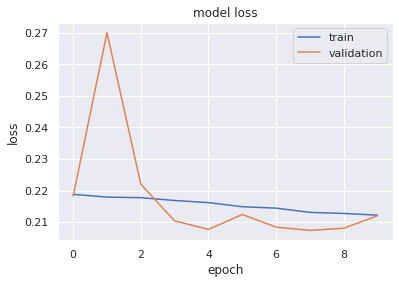

In [113]:
plt.plot(all_train_loss)
plt.plot(all_val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
# fig = plt.figure(figsize=(3,6))
plt.show()
# plt.savefig(model_dir + 'loss.png', bbox_inches='tight')

In [ ]:
df_loss = pd.DataFrame({'train_loss':all_train_loss})
df_loss['validation_loss'] = all_val_loss
df_loss.to_csv(model_dir + 'tra_exp_2.csv', sep=',')

In [54]:
model_dir = '/media/data/artifacts/2016/models/tra/'
df = pd.read_csv(model_dir + 'tra_exp_2.csv')
# df.columns=['epoch', 'train_loss', 'validation_loss']
df = df[['train_loss', 'validation_loss']]

[[<matplotlib.axis.XTick at 0x7f07f9fed310>,

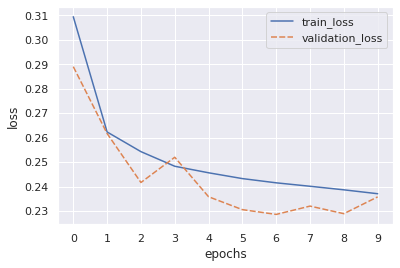

In [55]:
t = [x for x in range(0,10,1)]
sns.set(style="darkgrid")
g = sns.lineplot(data=df)
g.set(xlabel='epochs', ylabel='loss')
g.set(xticks=t)

In [139]:
torch.cuda.device_count()

1

### Save model

In [34]:
model_dir = '/media/data/artifacts/2016/models/tra/'
# torch.save(model, model_dir + "final-transfomer-4000-ep-20-5_2.pickle")
# model = torch.load(model_dir + "tra-5/" + "2-final-transfomer-4000-ep-10-5_5.pickle")
model = torch.load(model_dir + "final-tra-exp-256-1.pickle")
# model = torch.load(model_dir + 'final-transfomer.pickle', map_location=torch.device('cuda'))

### 

In [35]:
# device = torch.device("cpu")
# model= nn.DataParallel(model)
# model.to(device)

### Testing

In [36]:
def test(model, test_generator):
    test_losses = []
    num_correct = 0
    a_weights = []
    pred_label = []
    true_label = []
    prediction = []
    criterion = nn.BCELoss()
#     optimizer = optim.Adam(model.parameters(), lr=0.0005)
#     model.eval()
    with torch.no_grad():
        for inputs, labels in test_generator:
            inputs, labels = inputs.to(device).long(), labels.to(device)
            output, a_out = model(inputs)

            for out in output:
    #             o = out.cpu().numpy()
                prediction.append(out.cpu().numpy())
                #o = out.round().cpu().numpy()
                # if o[0] == 0 :   #this mean _label1_ bad
                #     pred_label.append(0)
                # else:            #this mean _label2_ good
                #     pred_label.append(1)


            for label in labels:
                l = label.cpu().numpy()
                if l[0] == 0 :
                    true_label.append(1) # malicious apps
                else:
                    true_label.append(0)

            for each_a_out in a_out:
                a = each_a_out
                a = a.squeeze()
                a = torch.mean(a,0) #if only 1 head
                a = torch.mean(a,0)
                a_weights.append(a.cpu().numpy())

            test_loss = criterion(output.squeeze(), labels.float())
            test_losses.append(test_loss.item())


#     print("Test loss: {:.3f}".format(np.mean(test_losses)))
#     test_acc = num_correct/len(test_generator.dataset)
    #print("Test accuracy: {:.3f}%".format(test_acc*100))
    return prediction, true_label, a_weights, test_losses

In [37]:
prediction, true_label, a_weights, test_losses = test(model,test_generator)
print("Test loss: {:.3f}".format(np.mean(test_losses)))

Test loss: 0.207


In [38]:
prediction1 = np.argmax(prediction, axis=1)  ## Prediction for bad reviews in terms of 0 and 1 for all test data
prediction_for_1=[] ## Prediction for bad reviews only
for each_prediction in prediction:
    prediction_for_1.append(each_prediction[1])

c = confusion_matrix(true_label,prediction1 )

In [39]:
c

array([[1495,   41],
       [ 105,  407]])

09-Mar-21 17:58:10 - Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
09-Mar-21 17:58:10 - NumExpr defaulting to 8 threads.


[Text(0, 0.5, 'benign'), Text(0, 1.5, 'malicious')]

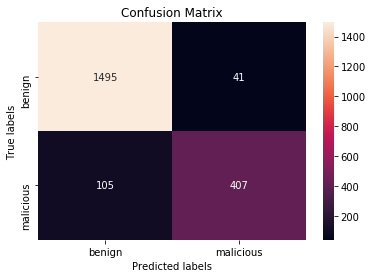

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(c, annot=True, fmt='g')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['benign', 'malicious']) 
ax.yaxis.set_ticklabels(['benign', 'malicious'])

#### Evaluation Metrics

In [41]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score
from inspect import signature

truelabel = true_label
predictedlabel = np.array(prediction1)

precision, recall, _ = precision_recall_curve(truelabel,np.array(prediction_for_1))
au = auc(recall, precision)
print("Area under graph "+str(au))
print("-------------------------------------------------")
rec_score = recall_score(truelabel,predictedlabel,pos_label=1,average='binary')
precise_score = precision_score(truelabel,predictedlabel,pos_label=1,average='binary')
f1 = f1_score(truelabel,predictedlabel,pos_label=1, average='binary')
print("Precision for Malicious apps "+str(precise_score))
print("Recall for Malicious apps "+str(rec_score))
print("F1-score for Malicious apps  " + str(f1))
print("-------------------------------------------------")
rec_score = recall_score(truelabel,predictedlabel,pos_label=0,average='binary')
precise_score = precision_score(truelabel,predictedlabel,pos_label=0,average='binary')
f1 = f1_score(truelabel,predictedlabel,pos_label=0, average='binary')
print("Precision for Benign apps "+str(precise_score))
print("Recall for Benign apps "+str(rec_score))
print("F1-score for Benign apps  " + str(f1))

Area under graph 0.9291419554663998
-------------------------------------------------
Precision for Malicious apps 0.9084821428571429
Recall for Malicious apps 0.794921875
F1-score for Malicious apps  0.8479166666666668
-------------------------------------------------
Precision for Benign apps 0.934375
Recall for Benign apps 0.9733072916666666
F1-score for Benign apps  0.9534438775510203


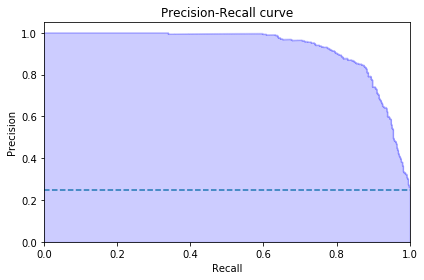

In [42]:
positive_cases = sum(truelabel)/len(truelabel)
plt.plot([0, 1], [positive_cases, positive_cases], linestyle='--')

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
                if 'step' in signature(plt.fill_between).parameters
                else {})
plt.step(recall, precision, color='b', alpha=0.2,
            where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.tight_layout()